In [172]:
import pandas
import os
import sys
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
from nilearn.datasets import MNI152_FILE_PATH
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.sandbox.stats.multicomp import multipletests

In [7]:
%matplotlib inline

In [2]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
gdf = pandas.read_csv(os.path.join(wdir,'gxp_correlation_wholebrain_results_NEW.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
bigdf = bigdf.values.T

In [4]:
# gdf = pandas.read_csv('/Users/jakevogel/Science/AHBA/MAIN_gcx_wholebrain_info_W_DKT_label.csv')
# gdf.columns

In [5]:
too_few = [x for x in gdf.structure_acronym.value_counts().index if gdf.structure_acronym.value_counts()[x] < 2]
gdf.loc[:,'new_structure_acronym'] = ['Other' if x in too_few else x for x in gdf.structure_acronym.values]

In [2]:
bigdf = pandas.DataFrame(bigdf)
tr,te = train_test_split(bigdf, stratify=gdf.new_structure_acronym.values, random_state=123)
tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z']]

In [ ]:
cca_mod = CCA()
cca_mod.fit(tr,tr_y)

In [6]:
plotr = pandas.concat([pandas.Series(cca_mod.predict(te)[:,0], index = te_y.index), 
                       pandas.Series(cca_mod.predict(te)[:,1], index = te_y.index), 
                       pandas.Series(te_y.loc[:,te_y.columns[0]]),
                       pandas.Series(te_y.loc[:,te_y.columns[1]]), 
                       gdf.loc[te_y.index,'slab_type']], 
                      axis=1)
plotr.columns = ['predicted_y', 'predicted_z', 'observed_y', 'observed_z', 'slab_type']

NameError: name 'cca_mod' is not defined

In [ ]:
#sns.set_context('paper')

In [ ]:
for i in range(2):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[i+2], data = plotr)
    plt.show()
    print(stats.pearsonr(cca_mod.predict(te)[:,i],te_y.loc[:,te_y.columns[i]]))

In [ ]:
for i in range(2):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[(3-i)], data = plotr)
    plt.show()
    print(stats.pearsonr(cca_mod.predict(te)[:,i],te_y.loc[:,te_y.columns[1-i]]))

In [ ]:
for i in range(2):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[i+2], col = 'slab_type', data = plotr)
    plt.show()

In [ ]:
for i in range(2):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[(3-i)], col = 'slab_type', data = plotr)
    plt.show()

In [ ]:
probes = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/normalized_microarray_donor10021/Probes.csv')
dx = pandas.concat([pandas.Series(cca_mod.x_loadings_[:,0]),
                   pandas.Series(cca_mod.x_loadings_[:,0])],
                   axis=1)
dx.loc[:,'symbol'] = probes.loc[:,'gene_symbol'].values
dx.loc[:,'name'] = probes.loc[:,'gene_name'].values

## PCA FIRST

In [6]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.7799918958717118

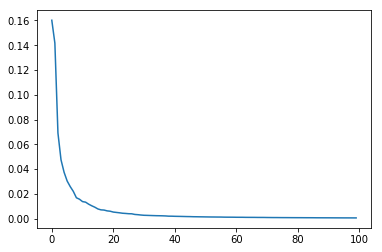

In [8]:
plt.plot(pcamod.explained_variance_ratio_)

In [9]:
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))

In [35]:
#pca_tfm = pandas.DataFrame(np.load('/Users/jakevogel/Dropbox/McGill/Neur608/Final_Project/stuff/train_PCA.npz'
#                                  )['arr_0'])

In [12]:
tr,te = train_test_split(pca_tfm, stratify=gdf.new_structure_acronym.values, random_state=123)
tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z']]

PERFORM KFOLD CV TO FIGURE OUT NUMBER OF COMPONENTS

In [41]:
from sklearn.cross_decomposition import PLSCanonical, PLSSVD

In [53]:
nc_chooser.loc[k*3:k*3+3]

,nc,estimator,r2,mae
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN


In [58]:
ncs = 10
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        pred = cross_val_predict(estimator, tr, tr_y, 
                                groups = gdf.loc[tr.index].slab_type, cv=10)
        nc_chooser.loc[i, 'r2'] = r2_score(y_true=tr_y, y_pred=pred)
        nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=tr_y, y_pred=pred)
        nc_chooser.loc[i, 'estimator'] = lab
        i+=1

1
2
3


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

4


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

5


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

6


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

7


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

8


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

9


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

10


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

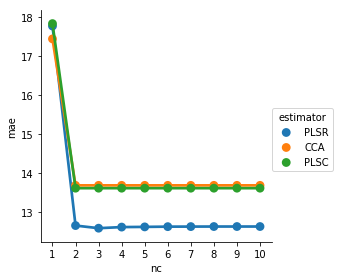

In [59]:
sns.factorplot(x = 'nc', y='mae', hue = 'estimator', data=nc_chooser)

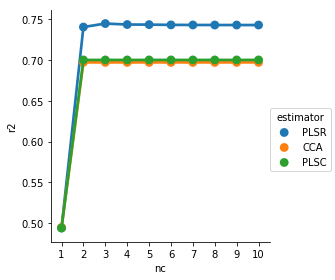

In [60]:
sns.factorplot(x = 'nc', y='r2', hue = 'estimator', data=nc_chooser)

Fit the PLSR model

In [74]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

evaluate model

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


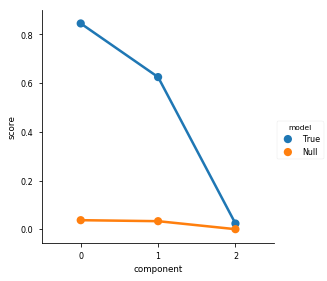

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***


In [65]:
# significant components?
results = evaluate_components(pls_mod, tr, tr_y)

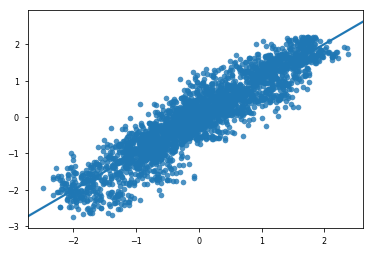

r2 = 0.845294923067, percent of total = 0.845294923067


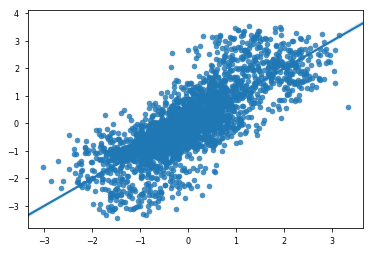

r2 = 0.624978064963, percent of total = 0.0966872796213


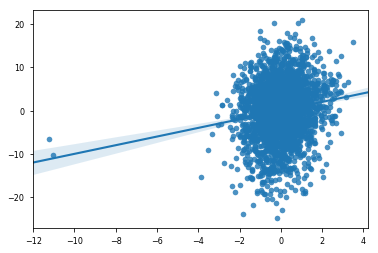

r2 = 0.0236249291993, percent of total = -0.0111101660466


In [88]:
# plot component scores
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    plt.close()
    sns.regplot(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])
    plt.show()
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = leftover * r2
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover = leftover - r2

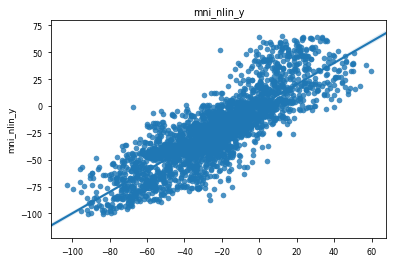

(0.84181211094001995, 0.0)
13.5543328282


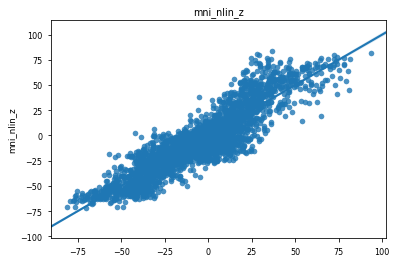

(0.89912412624303584, 0.0)
10.9062829537


In [111]:
# plot model fit
pred = pls_mod.predict(tr)
for i in range(tr_y.shape[-1]):
    plt.close()
    sns.regplot(pred[:,i], tr_y[tr_y.columns[i]])
    plt.title(tr_y.columns[i])
    plt.show()
    print(stats.pearsonr(pred[:,i], tr_y[tr_y.columns[i]]))
    print(mean_absolute_error(pred[:,i], tr_y[tr_y.columns[i]]))

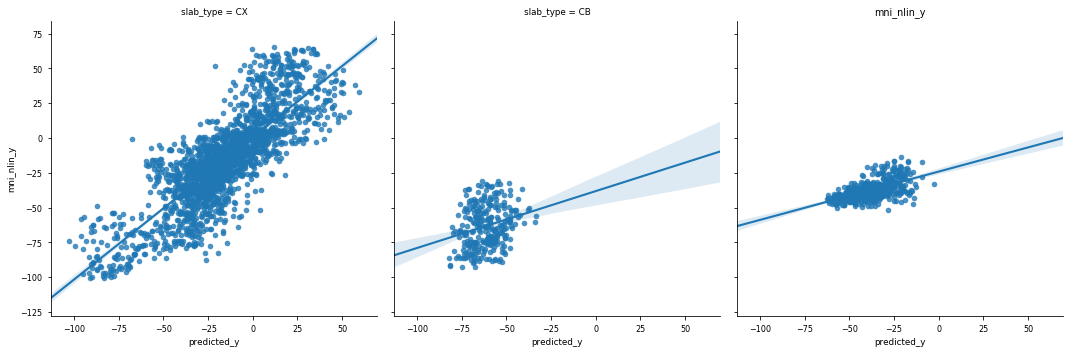

CX r2 =0.665441899848
CX mae =14.7974130567
CB r2 =0.0606174946054
CB mae =13.7261206233
BS r2 =0.316633434728
BS mae =7.67767781872


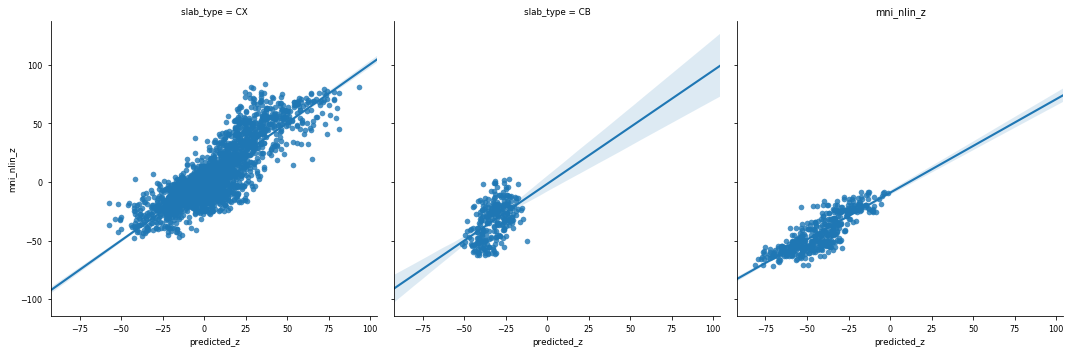

CX r2 =0.700633694255
CX mae =11.5231733012
CB r2 =0.228011592435
CB mae =11.6040786978
BS r2 =0.684404495612
BS mae =7.60692409269


In [112]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=tr_y.index), tr_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z'] + tr_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[tr.index,'slab_type']
for i in range(tr_y.shape[-1]):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+2], col = 'slab_type', data = preds_df)
    plt.title(preds_df.columns[i+2])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+2]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab][preds_df.columns[i+2]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

## Compare to test set

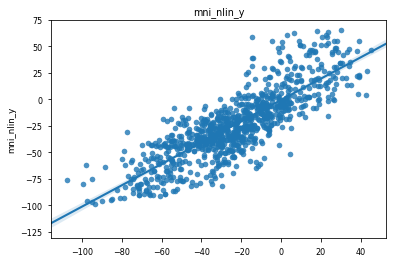

(0.8295033867078303, 5.6309575681050324e-236)
14.0657083154


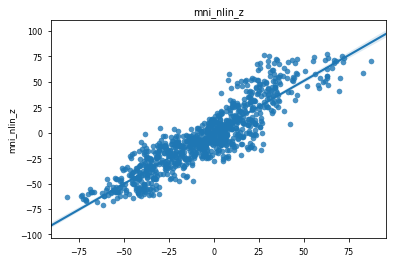

(0.89553409898549341, 0.0)
11.2391898356


In [115]:
# plot model fit
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))

## fit on entire dataset

In [120]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, gdf[['mni_nlin_y','mni_nlin_z']])

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:77: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:77: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


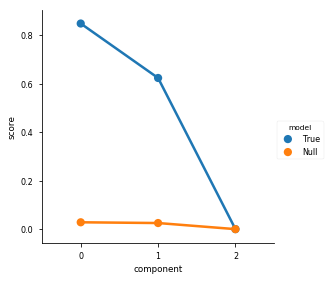

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***


In [122]:
# significant components?
results = evaluate_components(pls_mod, pca_tfm, gdf[['mni_nlin_y','mni_nlin_z']])

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:77: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


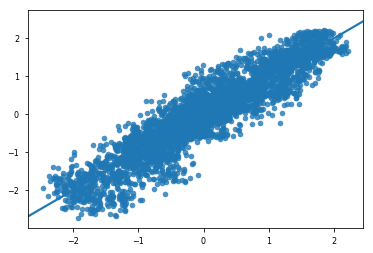

r2 = 0.848120882754, percent of total = 0.848120882754


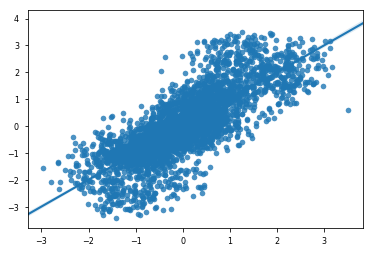

r2 = 0.623467002733, percent of total = 0.0946916180069


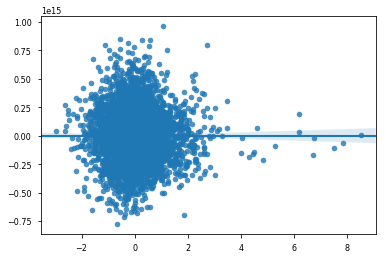

r2 = 1.50748146474e-29, percent of total = -7.10909996369e-30


In [125]:
pls_mod.fit(pca_tfm, gdf[['mni_nlin_y','mni_nlin_z']])
# plot component scores
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    plt.close()
    sns.regplot(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])
    plt.show()
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = leftover * r2
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover = leftover - r2

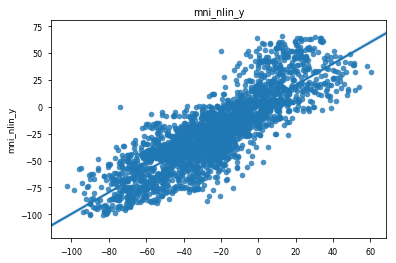

(0.84152652806162342, 0.0)
13.5916186894


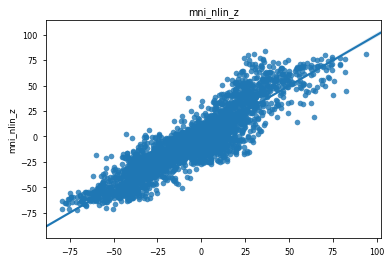

(0.89905582593927091, 0.0)
10.8844532271


In [127]:
# plot model fit
pred = pls_mod.predict(tr)
for i in range(tr_y.shape[-1]):
    plt.close()
    sns.regplot(pred[:,i], tr_y[tr_y.columns[i]])
    plt.title(tr_y.columns[i])
    plt.show()
    print(stats.pearsonr(pred[:,i], tr_y[tr_y.columns[i]]))
    print(mean_absolute_error(pred[:,i], tr_y[tr_y.columns[i]]))

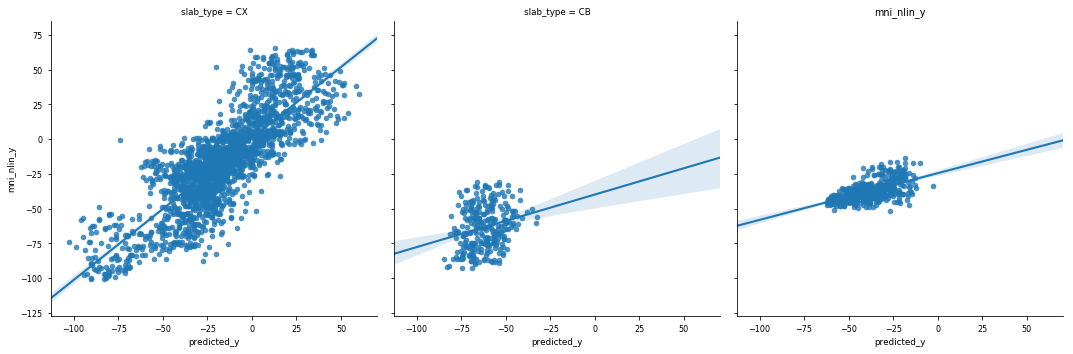

CX r2 =0.666370628414
CX mae =14.7850888396
CB r2 =0.0555817688552
CB mae =13.7831523232
BS r2 =0.305272185255
BS mae =7.9328614761


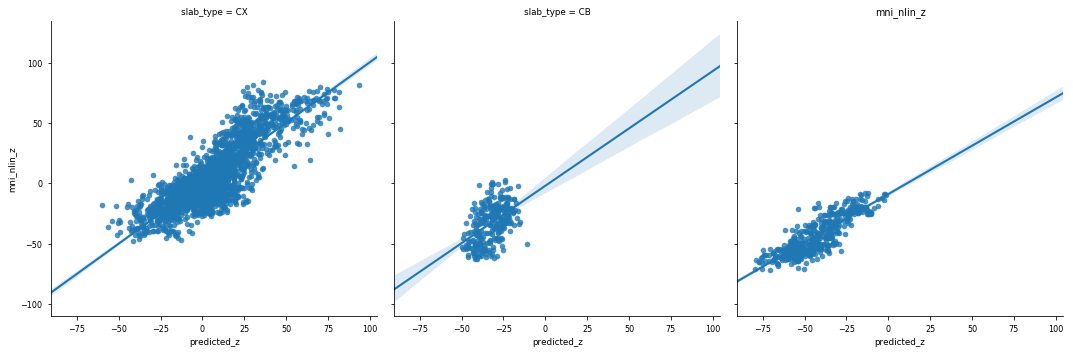

CX r2 =0.698902391389
CX mae =11.5423996094
CB r2 =0.225261343767
CB mae =11.5548222563
BS r2 =0.70399622488
BS mae =7.41169931522


In [128]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=tr_y.index), tr_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z'] + tr_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[tr.index,'slab_type']
for i in range(tr_y.shape[-1]):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+2], col = 'slab_type', data = preds_df)
    plt.title(preds_df.columns[i+2])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+2]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab][preds_df.columns[i+2]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

dkt regions

In [144]:
dkt = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_gcx_wholebrain_info_W_DKT_label.csv',
                        index_col=0)
dkt = dkt[pandas.notnull(dkt.dkt_region)]

In [146]:
preds_df.head()

,predicted_y,predicted_z,mni_nlin_y,mni_nlin_z,slab_type
1568,6.827351,10.648121,51.434769,-11.080622,CX
1945,-6.641099,-3.214101,-1.331985,2.938835,CX
56,31.864854,22.509426,51.313781,42.465737,CX
1462,0.526959,-6.417761,-5.367327,-13.881810,CX
1771,-20.055102,-9.801642,-16.528890,-14.745722,CX


In [170]:
regions = dkt.dkt_region.unique()
reg_results = pandas.DataFrame(index=regions, columns = ['n','r2_y','r2_z', 'p_permuted_y', 'p_permuted_z'])
for reg in regions:
    rdf = dkt[dkt.dkt_region==reg]
    reg_results.loc[reg,'n'] = len(rdf)
    preds = pls_mod.predict(pca_tfm.loc[rdf.index])
    pred_y = preds[:,0]
    r2y = stats.pearsonr(pred_y, rdf.loc[:,'mni_nlin_y'].values)[0]**2
    reg_results.loc[reg,'r2_y'] = r2y
    pred_z = preds[:,1]
    r2z = stats.pearsonr(pred_z, rdf.loc[:,'mni_nlin_z'].values)[0]**2
    reg_results.loc[reg,'r2_z'] = r2z
    
    r2s_y = []
    r2s_z = []
    for i in range(500):
        newy = np.random.permutation(range(len(pred_y)))
        r2s_y.append(stats.pearsonr(newy, rdf.loc[:,'mni_nlin_y'].values)[0]**2)
        newz = np.random.permutation(range(len(pred_z)))
        r2s_z.append(stats.pearsonr(newz, rdf.loc[:,'mni_nlin_z'].values)[0]**2)
    py = (len(np.array(r2s_y)[r2s_y>r2y])+1) / len(r2s_y)
    pz = (len(np.array(r2s_z)[r2s_z>r2z])+1) / len(r2s_z)
    reg_results.loc[reg,'p_permuted_y'] = py
    reg_results.loc[reg,'p_permuted_z'] = pz
    print('finished',reg)

finished  Putamen
finished  Basal forebrain
finished  Hypothalamus
finished  Insula
finished  Globus Pallidus
finished  Amygdala
finished  entorinal
finished  Hypothalamus???
finished  Lingual gyrus
finished  Hippocampus
finished  Pars opercularis
finished  Superior Temporal
finished  Precentral
finished  Inferior temporal
finished  Middle temporal
finished  Caudal middle frontal
finished  Superior frontal
finished  Lateral orbitofronal
finished  Medial orbitofrontal
finished  Caudal anterior cingulate
finished  Rostral middle frontal
finished  Rostral anterior cingulate
finished  Caudate
finished  L Cerebellum
finished  R Cerebellum
finished  Pars triangularis
finished  Posterior cingulate
finished  fusiform
finished  Lateral Occipital
finished  Paracentral 
finished  Precuneus
finished  Isthmus cingulate
finished  Inferior parietal
finished  Supramarginal
finished  Superior parietal
finished  Thalamus
finished  Transverse temporal
finished  Parahippocampal
finished  Postcentral
finis

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [176]:
reg_results.loc[:,'fdr_sig_y'] = multipletests(reg_results.p_permuted_y,method='fdr_bh')[0]
reg_results.loc[:,'fdr_Q_y'] = multipletests(reg_results.p_permuted_y,method='fdr_bh')[1]

reg_results.loc[:,'fdr_sig_z'] = multipletests(reg_results.p_permuted_z,method='fdr_bh')[0]
reg_results.loc[:,'fdr_Q_z'] = multipletests(reg_results.p_permuted_z,method='fdr_bh')[1]

In [ ]:
reg_results.loc[reg_results[(reg_results.fdr_sig_y==False) & (reg_results.fdr_sig_z==False)
                           ].index,'type'] = 1
reg_results.loc[reg_results[(reg_results.fdr_sig_y==False) & (reg_results.fdr_sig_z==True)
                           ].index,'type'] = 2
reg_results.loc[reg_results[(reg_results.fdr_sig_y==True) & (reg_results.fdr_sig_z==False)
                           ].index,'type'] = 3
reg_results.loc[reg_results[(reg_results.fdr_sig_y==True) & (reg_results.fdr_sig_z==True)
                           ].index,'type'] = 4

In [ ]:
for reg in reg_results.index:
    reg_results.loc[reg,'label'] = dkt[dkt.dkt_region==reg]['dkt_label'].values[0]
reg_results.loc[:,'label'] = [x-39 if x < 39 else x for x in reg_results.label.values]

In [195]:
reg_results.sort_values(['fdr_sig_y','fdr_sig_z'],ascending=False
                       ).to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_dkt_regional_results.csv')

In [ ]:
dkt_img = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii')
dat = dkt_img.get_data()
sigtype = np.zeros_like(dat)
for i,row in reg_results.iterrows():
    sigtype[dat==row['label']] = row['type']
ni.Nifti1Image(sigtype, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_sigtype')

In [ ]:
yr2_img = np.zeros_like(dat)
for i,row in reg_results.iterrows():
    yr2_img[dat==row['label']] = row['r2_y']
ni.Nifti1Image(yr2_img, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_r2_y')

zr2_img = np.zeros_like(dat)
for i,row in reg_results.iterrows():
    zr2_img[dat==row['label']] = row['r2_z']
ni.Nifti1Image(zr2_img, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_r2_z')

zp_img = np.zeros_like(dat)
for i,row in reg_results.iterrows():
    zp_img[dat==row['label']] = row['fdr_Q_z']
ni.Nifti1Image(zr2_img, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_fdrq_z')

yp_img = np.zeros_like(dat)
for i,row in reg_results.iterrows():
    yp_img[dat==row['label']] = row['fdr_Q_y']
ni.Nifti1Image(zr2_img, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_fdrq_y')

## Explaining y rotations!

In [131]:
print(pls_mod.y_rotations_, )
print(pls_mod.y_loadings_)
print(pls_mod.y_weights_)

[[ -6.28269075e-01  -1.09306756e+00   2.43345410e-16]
 [ -7.70544718e-01   8.90198611e-01   1.90667820e-15]]
[[ -6.35156711e-01  -5.49783658e-01   6.46315909e-16]
 [ -7.79903706e-01   4.48269987e-01   1.60344693e-15]]
[[ -6.35156711e-01  -5.49783658e-01   6.46315909e-16]
 [ -7.79903706e-01   4.48269987e-01   1.60344693e-15]]


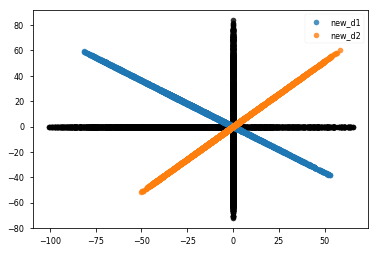

ORIGINAL AXES


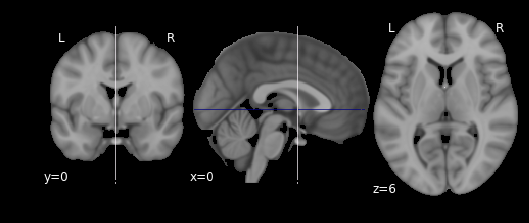

ROTATED AXES


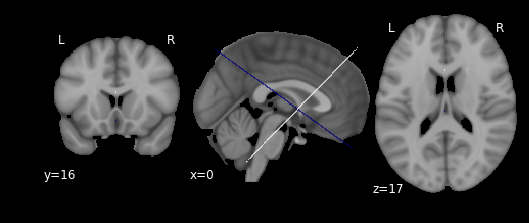

In [135]:
rotate_2d(pls_mod, gdf[['mni_nlin_y','mni_nlin_z']], component = 0, return_rotations = False, 
          mni_pth='/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')

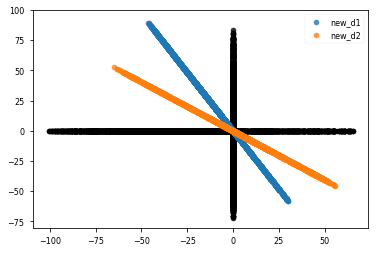

ORIGINAL AXES


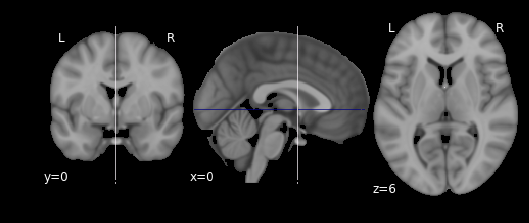

ROTATED AXES


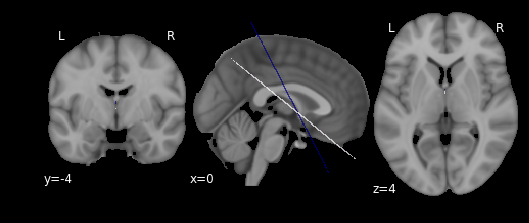

In [136]:
rotate_2d(pls_mod, gdf[['mni_nlin_y','mni_nlin_z']], component = 1, return_rotations = False, 
          mni_pth='/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')

## Exploring X!

TO DO
----------

* Plot gene expression image for each component
* Work on getting more out of the x features
    * Only keep certain Xs based on bootstrap ratio
    * Do GSEA stuff
* Do the previous with bootstrap ratio and loading
* Repeat with the second component



In [185]:
bsrx,_ = bootstrap_features(PLSRegression(n_components=3), pca_tfm, gdf[['mni_nlin_y','mni_nlin_z']])

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:77: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


In [191]:
c1 = np.dot(pcamod.components_.T, bsrx.loc[0])
c1 = pandas.concat([pandas.Series(c1), probes[['gene_symbol','gene_name']]], axis=1)

In [194]:
c1.sort_values(0,ascending=False).to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_c1_x_tfm.csv')

OTHER TO DO
============
* Plot DKT images 
* Update Evaluation script to pass results
* Update bootstrap script to return mean, se, and significance
* Explore adding x (3D)?
* Run analyses separately for every ROI and cluster
* Run for random spheres and cluster

## ADDING X

In [11]:
gdf.loc[:,'abs_mni_nlin_x'] = abs(gdf.mni_nlin_x.values)

NameError: name 'gdf' is not defined

In [12]:
tr,te = train_test_split(pca_tfm, stratify=gdf.new_structure_acronym.values, random_state=123)
tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

NameError: name 'pca_tfm' is not defined

In [13]:
plotr = pandas.concat([pandas.Series(cca_mod.predict(te)[:,0], index = te_y.index), 
                       pandas.Series(cca_mod.predict(te)[:,1], index = te_y.index),
                       pandas.Series(cca_mod.predict(te)[:,2], index = te_y.index),
                       pandas.Series(te_y.loc[:,te_y.columns[0]]),
                       pandas.Series(te_y.loc[:,te_y.columns[1]]),
                       pandas.Series(te_y.loc[:,te_y.columns[2]]),
                       gdf.loc[te_y.index,'slab_type']], 
                      axis=1)
plotr.columns = ['predicted_y', 'predicted_z', 'predicted x',
                 'observed_y', 'observed_z', 'observed_x', 'slab_type']

SyntaxError: invalid syntax (<ipython-input-13-186986e08cb9>, line 4)

In [ ]:
for i in range(3):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[i+3], data = plotr)
    plt.show()
    print(stats.pearsonr(cca_mod.predict(te)[:,i],te_y.loc[:,te_y.columns[i]]))

In [ ]:
for i in range(3):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[i+3], col = 'slab_type', data = plotr)
    plt.show()

## less components

In [ ]:
cca_mod = PLSRegression(n_components=1)
cca_mod.fit(tr,tr_y)

Notes
================

* PCA first then PLS works plenty well and also very fast -- will support 10-fold CV (0.83, 0.89, 0.74)
* Keeping the same number of components as Ys leaves Ys orthogonal
* Y and Z are predicted well (r < 0.8), x not nearly as well (r ~ 0.5)
* Combination X,Y,Z, with 1 component seems to favor Z but cost all three (0.53, 0.80, 0.40)
* Combination X,Y,Z with 2 components maintains Y (0.8) and combines Z and X (0.82, 0.60).
* Forcing Z and Y together (no X) hurts both (0.63, 0.78)
* It seems 

In [14]:
np.random.permutation?

In [1]:
def evaluate_components(clf, x, y, n_iterations=500, check = 100,
                       evaluate = True, plot = True, thr = 0.95):
    
    if type(x) != type(pandas.DataFrame()):
        x = pandas.DataFrame(x)
    
    # fit model
    clf.fit(x,y)
    n_comps = clf.n_components
    
    # prepare output
    results = pandas.DataFrame(index = range(n_comps * (n_iterations+1)),
                              columns = ['score', 'component', 'model'])
    results.loc[:,'component'] = list(range(n_comps))*(n_iterations+1)
    results.loc[range(n_comps),'model'] = ['True']*n_comps
    results.loc[range(n_comps,n_comps*(n_iterations+1)), 'model'
               ] = ['Null']*(n_comps*n_iterations)
    
    true_scores = [stats.pearsonr(clf.x_scores_[:,x], clf.y_scores_[:,x]
                                 )[0]**2 for x in range(n_comps)]
    results.loc[results[results.model=='True'].index,'score'] = true_scores
    
    k = clf.n_components
    # permute and refit model
    for i in range(n_iterations):
        new_ind = np.random.permutation(x.index)
        new_x = x.loc[new_ind]
        newmod = clf.fit(new_x,y)
        new_scores = [stats.pearsonr(newmod.x_scores_[:,x], newmod.y_scores_[:,x]
                                 )[0]**2 for x in range(n_comps)]
        results.loc[range(k, k+n_comps), 'score'] = new_scores
        if check:
            if i % check == 0:
                print('finished iteration',i)
        
        k += n_comps
        
    if evaluate:
        if plot:
            cr = display_results(results, thr)
        else:
            cr = display_results(results, thr, False)
        
    return results, cr

def display_results(results, thr = 0.95, plot=True):
    
    if plot:
        # plot components
        sns.set_context('paper')
        plt.close()
        sns.factorplot(x='component', y = 'score', hue='model', data=results)
        plt.show()
    
    # get p-values
    comp_results = pandas.DataFrame(index=results.component.unique(),
                                   columns = ['p','sig'])
    for i in results.component.unique():
        nullz = results[(results.component==i) & (results.model=='Null')
                       ]['score'].sort_values().values
        real = results[(results.component==i) & (results.model=='True')]['score'].values[0]
        p = (len(nullz[nullz>real])+1) / len(nullz)
        if p < (1 - thr):
            comp_results.loc[i] = [p, 1]
            print('component %s: p = %s  ***'%(i,p))
        else:
            comp_results.loc[i] = [p, 0]
            print('component %s: p = %s'%(i,p))
    
    return comp_results

In [181]:
def rotate_2d(clf, y, component = 0, return_rotations = False, mni_pth=None, vs=1, 
              provide_rotations = None):
    
    if type(y) == type(pandas.DataFrame()):
        y = y.values
    d1 = y[:,0]
    d2 = y[:,1]
    
    if type(provide_rotations) != None:
        d1_wt = clf.y_rotations_[0, component]
        d2_wt = clf.y_rotations_[1, component]
    else:
        d1_wt = provide_rotations[0, component]
        d2_wt = provide_rotations[1, component]
    null = np.zeros(len(d1))
    
    d1_rot_x = d1 * np.cos(d1_wt) - null * np.sin(d1_wt)
    d1_rot_y = d1 * np.sin(d1_wt) + null * np.cos(d1_wt)
    d2_rot_x = null * np.cos(d2_wt) - d2 * np.sin(d2_wt)
    d2_rot_y = null * np.sin(d2_wt) + d2 * np.cos(d2_wt)
    
    plt.close()
    sns.regplot(x = d1, y = null, fit_reg=False, color = 'k')
    sns.regplot(x = null, y = d2, fit_reg=False, color = 'k')
    sns.regplot(x = d1_rot_x, y = d1_rot_y, fit_reg=False, label = 'new_d1')
    sns.regplot(x = d2_rot_x, y = d2_rot_y, fit_reg=False, label = 'new_d2')
    plt.legend()
    plt.show()
    
    if mni_pth:
        print('ORIGINAL AXES')
        mni_display(mni_pth, d1, null, null, d2, vs)
        print('ROTATED AXES')
        mni_display(mni_pth, d1_rot_x, d1_rot_y, d2_rot_x, d2_rot_y, vs)
    
    if return_rotations:
        return d1_rot_x, d1_rot_y, d2_rot_x, d2_rot_y
        
def mni_display(mni_pth, x1, x2, y1, y2, vs=1):
    
    mni = ni.load(mni_pth)
    axes = np.zeros_like(mni.get_data())
    
    iy = [convert_coords((0, x1[x], x2[x]), to_what='xyz', vs=vs) for x in range(len(x2))]
    iz = [convert_coords((0,  y1[x], y2[x]), to_what='xyz', vs=vs) for x in range(len(y2))]
    
    for coord in iy:
        coord = tuple([int(round(x)) for x in coord]) 
        axes[coord] = 1
    for coord in iz:
        coord = tuple([int(round(x)) for x in coord]) 
        axes[coord] = 2
    
    axes_img_null = ni.Nifti1Image(axes, affine=mni.affine)
    plt.close()
    plotting.plot_roi(axes_img_null, mni,  draw_cross=False)
    plt.show()

In [134]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]

    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs

    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]

    else:
        raise IOError('please set to_what to either mni or xyz')

    return x,y,z

In [ ]:
convert_coords([0,0,0], to_what='xyz')

In [ ]:
mni = ni.load(MNI152_FILE_PATH)


## Features

In [39]:
cca_mod.x_loadings_.shape

(100, 20)

In [40]:
cca_mod.x_weights_.shape

(100, 20)

In [41]:
cca_mod.coef_.shape

(100, 2)

In [44]:
tr.shape

(2776, 100)

In [45]:
np.random.choice?

In [ ]:
def bootstrap_features(clf, x, y, n_iterations=500, check = 100, on ='x'):
    
    if type(x) != type(pandas.DataFrame()):
        x = pandas.DataFrame(x)
    if type(y) != type(pandas.DataFrame()):
        y = pandas.DataFrame(y)
    
    # fit model
    orig = clf.fit(x,y)
    
    # prepare output
    n_feats_x = x.shape[-1]
    n_feats_y = y.shape[-1]
    all_results_x = {}
    all_results_y = {}
    
    for i in range(orig.n_components):
        results = pandas.DataFrame(index = range(n_iterations), columns = range(n_feats_x))
        all_results_x.update({i: results})
        results = pandas.DataFrame(index = range(n_iterations), columns = range(n_feats_y))
        all_results_y.update({i: results})
    bs_ratio_x = pandas.DataFrame(index = range(orig.n_components), 
                                columns = range(n_feats_x))
    bs_ratio_y = pandas.DataFrame(index = range(orig.n_components), 
                                columns = range(n_feats_y))
    
    # bootstrap
    for i in range(n_iterations):
        n_ind = np.random.choice(x.index, len(x.index))
        n_samp = pandas.DataFrame(x.loc[n_ind],copy=True)
        newmod = clf.fit(n_samp,y)
        for c in range(orig.n_components):
            xcorrs = [stats.pearsonr(orig.x_loadings_[:,c],
                                     newmod.x_loadings_[:,x])[0]**2 for x in range(orig.n_components)]
            closest = np.argmax(xcorrs)
            all_results_x[c].loc[i] = newmod.x_loadings_[:,closest]
            all_results_y[c].loc[i] = newmod.y_loadings_[:,closest]
        if check:
            if i % check == 0:
                print('finished iteration',i)
    
    # calculate bootstrap ratio
    bs_ratio_x = bootstrap_ratio(all_results_x, bs_ratio_x)
    bs_ratio_y = bootstrap_ratio(all_results_y, bs_ratio_y)
    
    return bs_ratio_x, bs_ratio_y
    
def bootstrap_ratio(all_results, bs_ratio):

    all_stats = {'means': pandas.DataFrame(index = bs_ratio.index, columns = bs_ratio.column),
                'se': pandas.DataFrame(index = bs_ratio.index, columns = bs_ratio.column),
                 'bs': pandas.DataFrame(index = bs_ratio.index, columns = bs_ratio.column),
                'p': pandas.DataFrame(index = bs_ratio.index, columns = bs_ratio.column)}
    
    for i,res in all_results.items():
        mn = res.mean()
        sem = res.sem()
        all_stats['bs'].loc[i] = mn / sem
        all_stats['mean'].loc[i] = mn
        all_stats['se'].loc[i] = sem
        bs05 
        
        
    return bs_ratio

        

In [ ]:
def back_transform_fmri(weights, component_matrix)

    weight_tfm = np.dot(component_matrix.T, weights)
    mat = np.zeros((272,272))
    mat[np.tril_indices_from(mat,k=-1)] = weight_tfm
    i_upper = np.triu_indices_from(mat, -1)
    mat[i_upper] = mat.T[i_upper]

In [ ]:
cca_mod.n_components

In [ ]:
def back_transform